# Exponential data 01

# _Josep Fortiana_ $\hskip6cm$ 2022-03-28

## _Insurance claims_ - Stan version

Adapted from a blog entry [by Markus Gesmann (19 May 2015)](https://magesblog.com/post/2015-05-19-posterior-predictive-output-with-stan/),    
an example from section 16.17 in  Klugman, S. A., Panjer, H. H. & Willmot, G. E. (2004), _Loss Models: From Data to Decisions,_ Wiley Series in Probability and Statistics.

***
###### LaTeX macros
$\def\prob{P}$
$\def\argmax{\operatorname{arg\,max}}$
$\def\argmin{\operatorname{arg\,min}}$
$\def\borel{\operatorname{Borel}}$
$\def\cE{\cal E}$
$\def\cP{\cal P}$
$\def\R{\mathbb{R}}$ 
$\def\N{\mathbb{N}}$
$\def\Z{\mathbb{Z}}$
$\def\Ee{\operatorname{E}}$
$\def\va{\text{v.a.}}$
$\def\var{\operatorname{var}}$
$\def\cov{\operatorname{cov}}$
$\def\cor{\operatorname{cor}}$
$\def\binomdist{\operatorname{Binom}}$
$\def\berndist{\operatorname{Ber}}$
$\def\betabinomdist{\operatorname{Beta-Binom}}$
$\def\betadist{\operatorname{Beta}}$
$\def\expdist{\operatorname{Exp}}$
$\def\gammadist{\operatorname{Gamma}}$
$\def\hyperdist{\operatorname{Hypergeom}}$
$\def\hypergeomdist{\operatorname{Hypergeom}}$
$\DeclareMathOperator{\multinomialdist}{Multinomial}$
$\DeclareMathOperator{\multinomdist}{Multinom}$
$\def\poissondist{\operatorname{Poisson}}$
$\def\geomdist{\operatorname{Geom}}$
$\def\normaldist{\operatorname{N}}$
$\def\unifdist{\operatorname{Unif}}$
$\DeclareMathOperator{\indica}{\mathbb{1}}$
$\def\CondTo{\mathbin{|\mskip0.5mu}}$
***

# 00 - An insurance Problem

Set or adjust the premium for a customer of three years according to a prediction of the expected claims cost for the next year.

# 01 - Model

## Likelihood

The claims distribution is believed to follow an exponential distribution with parameter $\theta$. 

$$
    \begin{array}{lcl}
     x_{i} &\sim &\expdist (\theta),\mskip40mu 1\leq i\leq n.
    \end{array}
$$

## Prior

The prior parameter distribution on $\theta$ is assumed to be a Gamma distribution with parameters $\alpha=4$, $\beta=1000$:
 
$$
\mskip-80mu
    \begin{array}{lcl}
        \theta &\sim &\operatorname{Gamma}(\alpha,\beta),
    \end{array}
$$

In [1]:
## Prior parameters 
prior.a <- 4
prior.b <- 1000

In [2]:
Theor.prior.mean<-prior.a/prior.b
Theor.prior.var<-prior.a/prior.b^2
Theor.prior.sd<-sqrt(Theor.prior.var)
round(Theor.prior.mean,4)
round(Theor.prior.var,6)
round(Theor.prior.sd,3)

[1] 0.004

[1] 4e-06

[1] 0.002

I have three independent observations, namely losses 100, 950 and 450. 

In [3]:
## Observed data
claims.obs <- c(100, 950, 450)
n <- length(claims.obs)

In [4]:
# Average loss
round(sum(claims.obs)/n,3)

[1] 500

# Analytical solution: a conjugate model

In [5]:
posterior.a <- prior.a + n
posterior.b <- prior.b + sum(claims.obs)

In this case the predictive distribution (both prior and posterior) is a [Pareto II (Lomax)](https://en.wikipedia.org/wiki/Lomax_distribution) distribution with density:

$$
    f(x|\alpha,\beta)=\dfrac{\alpha\cdot\beta^{\alpha}}{(x+\beta)^{\alpha+1}},\mskip20mu x\geq 0,
$$
 
and a mean of $\dfrac{\beta}{\alpha-1}$.

In [6]:
# Prior predictive expectation
round(prior.b/(prior.a-1),3)

[1] 333.333

The posterior predictive expected loss:

In [7]:
# Posterior predictive expectation
round(posterior.b/(posterior.a-1),3)

[1] 416.667

In [8]:
#install.packages("actuar", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(actuar) # Required for pareto distribution

Loading required package: actuar

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘actuar’”


# Stan simulation

In [9]:
#install.packages("rstan", dependencies=TRUE,repos= "https://cloud.r-project.org")
require(rstan)
# Following directions:
# For execution on a local, multicore CPU with excess RAM we recommend calling
# options(mc.cores = parallel::detectCores()).
# To avoid recompilation of unchanged Stan programs, we recommend calling
# rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

Loading required package: rstan

Loading required package: StanHeaders

Loading required package: ggplot2

rstan (Version 2.21.5, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)



In [10]:
stanmodelcode <- "
data {
    int<lower=0> n;
    real<lower=0> prior_a;
    real<lower=0> prior_b;
    real<lower=0> y[n];
    }
parameters {
    real<lower=0.00001> theta;
    }
model {
    theta ~ gamma(prior_a,prior_b);
    y~exponential(theta);
    }
generated quantities{                // Sampling from the theta posterior
    real y_pred;
    y_pred = exponential_rng(theta);
    }
    "

In [11]:
stanDso <- stan_model(model_code = stanmodelcode) 

In [12]:
dat <- list(n = n, y = claims.obs, prior_a=prior.a, prior_b=prior.b); 

In [13]:
fit <- sampling(stanDso, data = dat, iter = 20000, warmup=1000) 
fit

## Inference for Stan model: stanmodelcode.
## 4 chains, each with iter=10000; warmup=200; thin=1; 
## post-warmup draws per chain=9800, total post-warmup draws=39200.
## 
##          mean se_mean     sd   2.5%    25%    50%    75%   97.5% n_eff Rhat
## Theta    0.00    0.00   0.00   0.00   0.00   0.00   0.00    0.01 13756    1
## y_pred 416.86    2.85 492.28   8.83 106.34 262.70 542.47 1730.55 29773    1
## lp__   -48.65    0.01   0.70 -50.68 -48.83 -48.38 -48.20  -48.15 14203    1
## 
## Samples were drawn using NUTS(diag_e) at Tue May 19 06:06:08 2015.
## For each parameter, n_eff is a crude measure of effective sample size,
## and Rhat is the potential scale reduction factor on split chains (at 
## convergence, Rhat=1).

Inference for Stan model: cc094e5ef825be956dcbd840475ea592.
4 chains, each with iter=20000; warmup=1000; thin=1; 
post-warmup draws per chain=19000, total post-warmup draws=76000.

         mean se_mean     sd   2.5%    25%    50%    75%   97.5% n_eff Rhat
theta    0.00    0.00   0.00   0.00   0.00   0.00   0.00    0.01 25558    1
y_pred 419.58    2.08 498.47   8.88 104.73 260.97 549.75 1767.16 57211    1
lp__   -48.66    0.00   0.73 -50.74 -48.82 -48.38 -48.20  -48.15 25547    1

Samples were drawn using NUTS(diag_e) at Wed Apr 27 18:36:25 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [14]:
theta <- extract(fit, 'theta')
theta <- unlist(theta, use.names=FALSE)
y_pred <- extract(fit, 'y_pred')
y_pred <- unlist(y_pred, use.names=FALSE)

ERROR: Error in dpareto(x, posterior.a, posterior.b): could not find function "dpareto"


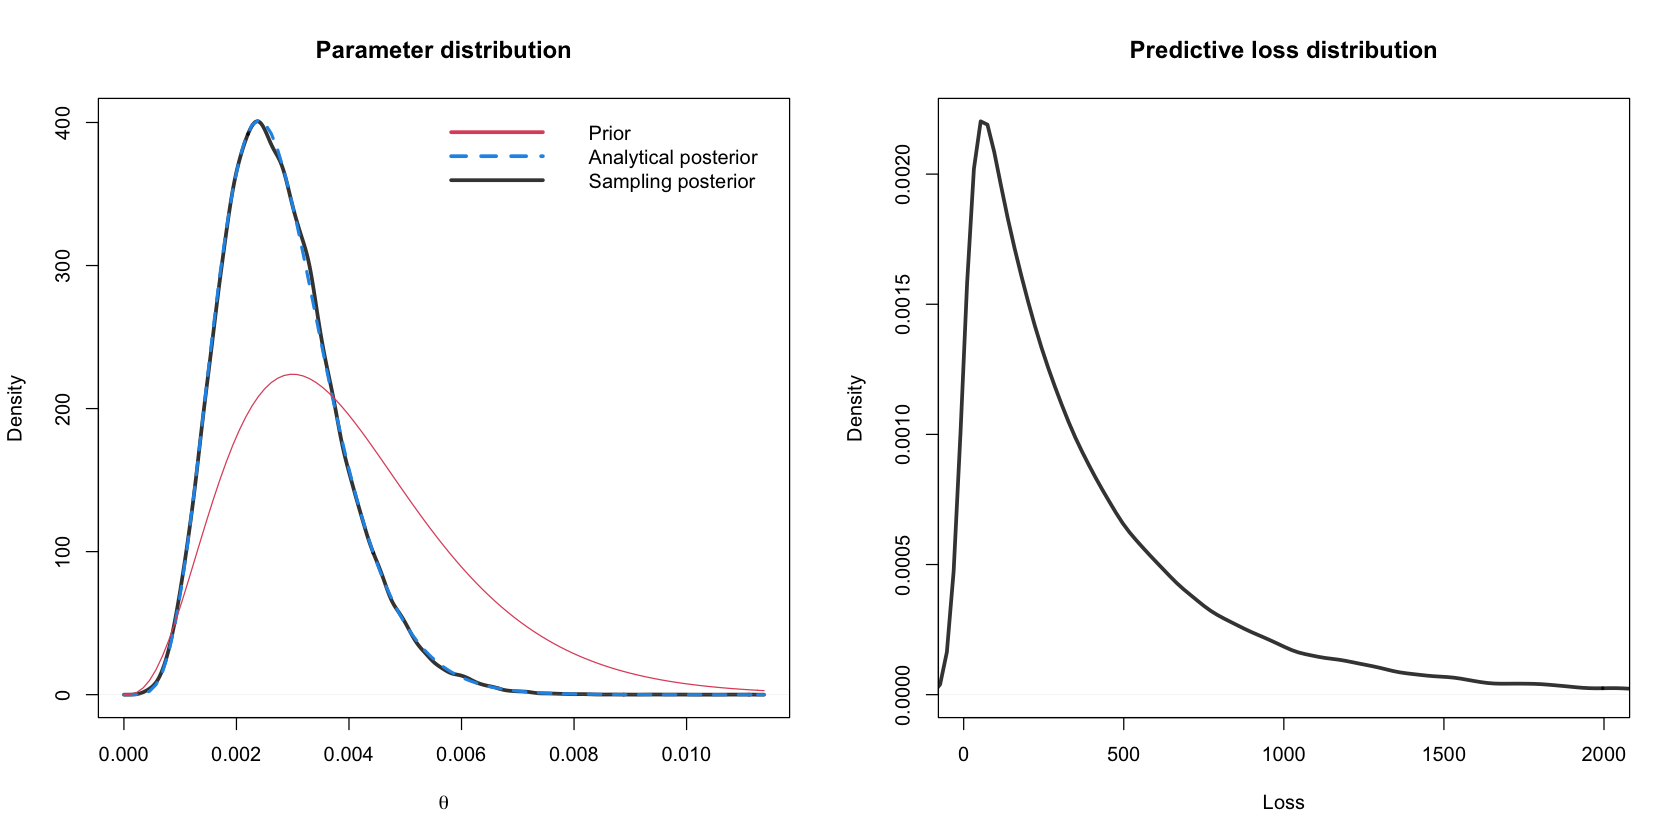

In [15]:
options(repr.plot.width=14,repr.plot.height=7)
old.par<- par(mfrow=c(1,2))
# Simulated posterior parameter
plot(density(theta),
     xlab=expression(theta), col=grey(0, 0.8),lwd=3,
     main="Parameter distribution")
# Analytical posterior parameter
curve(dgamma(x, posterior.a, posterior.b), 
      add=TRUE, col=4, lty=2, lwd=2.5)
# Analytical prior parameter
curve(dgamma(x, prior.a, prior.b), 
      add=TRUE, col=2)
legend(x=0.005,y=410,legend=c("Prior", "Analytical posterior", "Sampling posterior"), 
           col=c(2, 4, grey(0, 0.8)), lty=c(1,2,1), bty="n",lwd=3)
# Simulated posterior predictive
plot(density(y_pred), xlim=c(1,2000),
     xlab="Loss", col=grey(0, 0.8),
     main="Predictive loss distribution",lwd=3)
# Analytical posterior predictive
curve(dpareto(x, posterior.a, posterior.b), 
      add=TRUE, col=4, lwd=1.5, lty=2,5)
# Analytical prior predictive
curve(dpareto(x, prior.a, prior.b), 
      add=TRUE, col=2,lwd=3)
legend(x=920,y=0.0023, legend=c("Prior","Analytical posterior", "Sampling posterior"),
           col=c(2, 4, grey(0, 0.8)),lwd=3, lty=c(1,2,1), bty="n")
par(old.par)

### Quantiles and probabilities

In [ ]:
round(qpareto(0.75, prior.a, prior.b),3)
round(qpareto(0.75, posterior.a, posterior.b),3)
round(quantile(y_pred, 0.75),3)

In [ ]:
round(ppareto(950, posterior.a, posterior.b),3)
round(ecdf(y_pred)(950),3)

The Stan output shows a simulated posterior predictive expected loss $\approx 417$, close to the analytical answer $416.667$.

Also the $75\%$ percentile of the posterior predictive distribution is a loss of $\approx 547$ vs. $\approx 414$ from the prior predictive.

That means every four years I shouldn't be surprised to observe a loss in excess of 500.

Further I note that 90% of losses are expected to be less than 950, or in other words the observation in my data may reflect the outcome of an event with a 1 in 10 return period.

Comparing the sampling output from Stan with the analytical output gives me some confidence that I am doing the ‘right thing'.